In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import cartopy.crs as ccrs
import nclcmaps
import numpy as np
import pandas as pd
import os

dir = "."

cmap_BWOR = nclcmaps.cmap('BlueWhiteOrangeRed')
cmap_BR = nclcmaps.cmap('BlRe')
cmap_WBGYR = nclcmaps.cmap('WhiteBlueGreenYellowRed')

## data overview

From the README.txt:

> This folder contains the following four NetCDF files (NetCDF 4) with 2m temperature data from ERA5:
>
> 1. era5_2t_hourly_202307.nc: Hourly data for July 2023.
> 2. era5_2t_daymean_clim1991-2020_lowpass_07.nc: Daily mean 2m temperature climatology for July based on the 1991-2020 reference period.
> 3. era5_2t_daymax_clim1991-2020_lowpass_07.nc: Daily maximum 2m temperature climatology for July based on the 1991-2020 reference period.
> 4. era5_2t_daymin_clim1991-2020_lowpass_07.nc: Daily minimum 2m temperature climatology for July based on the 1991-2020 reference period.


## data check
Let's start exploring the data. A good sanity check would be to try to reproduce the map below [published by C3S](https://climate.copernicus.eu/surface-air-temperature-july-2023):

![temp-anomaly-map](https://climate.copernicus.eu/sites/default/files/ftp-data/temperature/2023/07/ERA5_1991-2020/map_1month_anomaly_Global_ea_2t_202307_1991-2020_v02.1.pdf)

In [2]:
# load data
t2_hourly = xr.open_dataset(dir + "/data/era5_2t_hourly_202307.nc")
t2_clim_daymax = xr.open_dataset(dir + "/data/era5_2t_daymax_clim1991-2020_lowpass_07.nc")
t2_clim_daymean = xr.open_dataset(dir + "/data/era5_2t_daymean_clim1991-2020_lowpass_07.nc")
t2_clim_daymin = xr.open_dataset(dir + "/data/era5_2t_daymin_clim1991-2020_lowpass_07.nc")

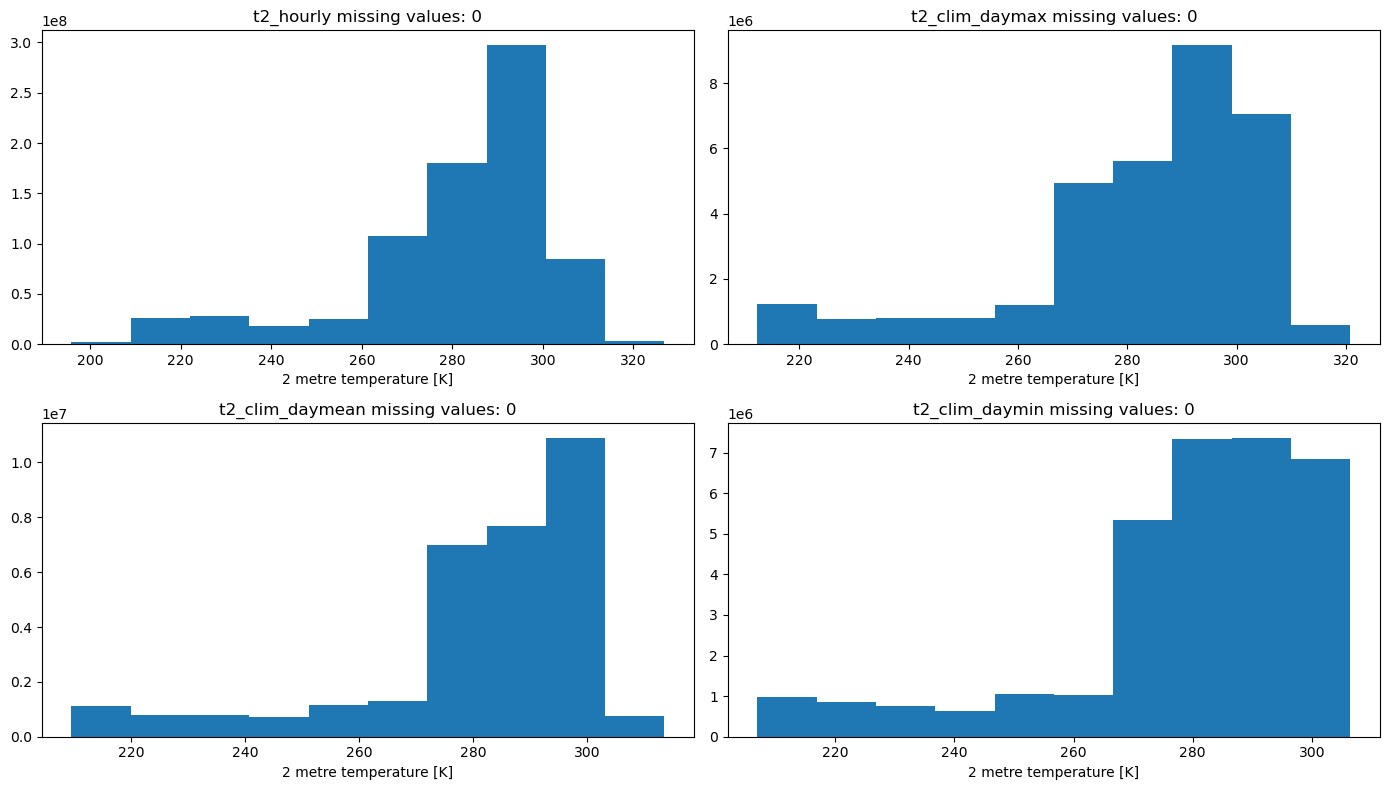

In [3]:
# quick histograms to ckeck for outliers
# -> distributions look reasonable; no missing values
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

t2_hourly['2t'].plot.hist(ax=axs[0,0])
t2_clim_daymax['2t'].plot.hist(ax=axs[0,1])
t2_clim_daymean['2t'].plot.hist(ax=axs[1,0])
t2_clim_daymin['2t'].plot.hist(ax=axs[1,1])

axs[0,0].set_title("t2_hourly missing values: " + str(t2_hourly['2t'].isnull().sum().values))
axs[0,1].set_title("t2_clim_daymax missing values: " + str(t2_clim_daymax['2t'].isnull().sum().values))
axs[1,0].set_title("t2_clim_daymean missing values: " + str(t2_clim_daymean['2t'].isnull().sum().values))
axs[1,1].set_title("t2_clim_daymin missing values: " + str(t2_clim_daymin['2t'].isnull().sum().values))

fig.tight_layout()

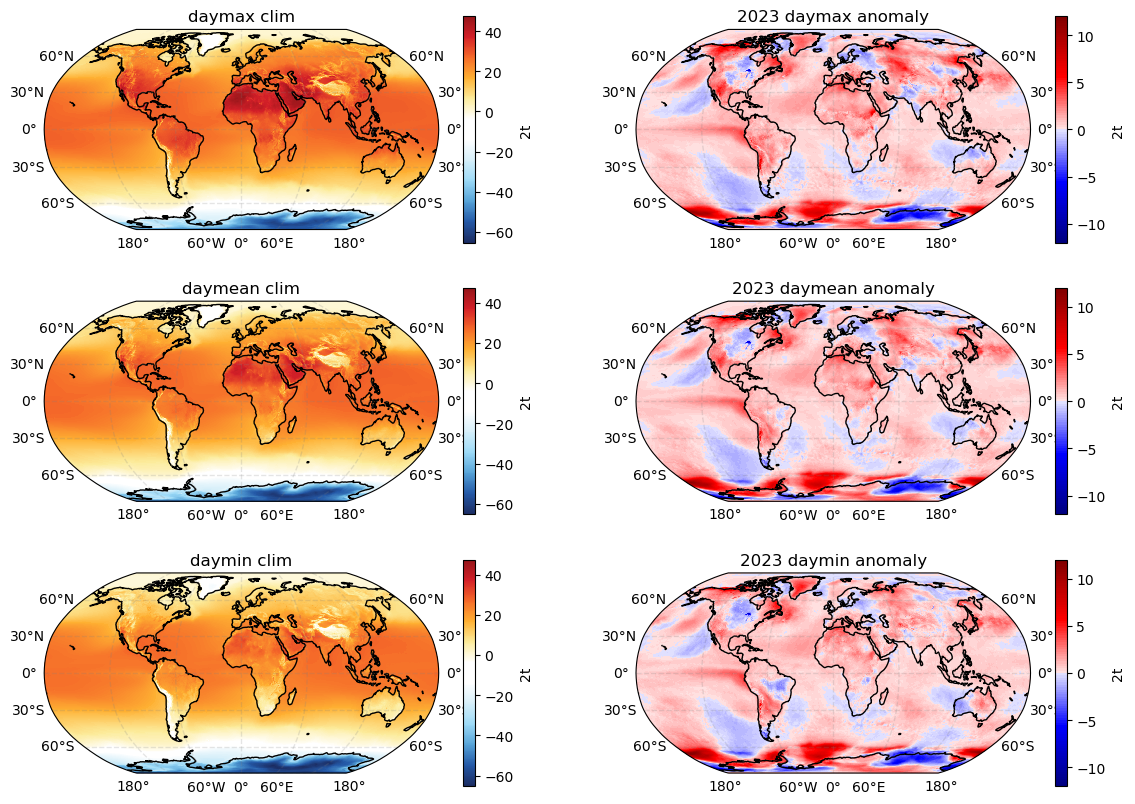

In [4]:
# let's get an overview of whole-month means for the three metrics
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))

def plot_map(da, ax, min, max, title, cmap, cbar_kwargs=None):
    if cbar_kwargs is None:
        cbar_kwargs = {}
    da.plot(
        ax = ax,
        transform=ccrs.PlateCarree(),  # the data's projection
        vmin = min, vmax = max,
        cmap = cmap,
        cbar_kwargs=cbar_kwargs  # optionally pass colorbar settings
    )
    ax.set_title(title)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels = None

# climatologies
july_mean = t2_clim_daymean.mean('time') - 273.15
july_max = t2_clim_daymax.mean('time') - 273.15
july_min = t2_clim_daymin.mean('time') - 273.15

# get min and max values for contours
min_val_clim = july_min['2t'].min()
max_val_clim = july_max['2t'].max()

plot_map(july_max['2t'], axes[0,0], min_val_clim, max_val_clim, 'daymax clim', cmap_BWOR)
plot_map(july_mean['2t'], axes[1,0], min_val_clim, max_val_clim, 'daymean clim', cmap_BWOR)
plot_map(july_min['2t'], axes[2,0], min_val_clim, max_val_clim, 'daymin clim', cmap_BWOR)

# 2023 anomalies
daymean_anomaly = t2_hourly.resample(time='D').mean().mean('time') - 273.15 - july_mean
daymax_anomaly = t2_hourly.resample(time='D').max().mean('time') - 273.15 - july_max
daymin_anomaly = t2_hourly.resample(time='D').min().mean('time') - 273.15 - july_min

plot_map(daymax_anomaly['2t'], axes[0,1], -12, 12, '2023 daymax anomaly', cmap_BR)
plot_map(daymean_anomaly['2t'], axes[1,1], -12, 12, '2023 daymean anomaly', cmap_BR)
plot_map(daymin_anomaly['2t'], axes[2,1], -12, 12, '2023 daymin anomaly', cmap_BR)

# sanity check: the 2023 daymean anomaly map seems consistent to the published C3S map at
# https://climate.copernicus.eu/surface-air-temperature-july-2023
# though note the nonlinear colormap


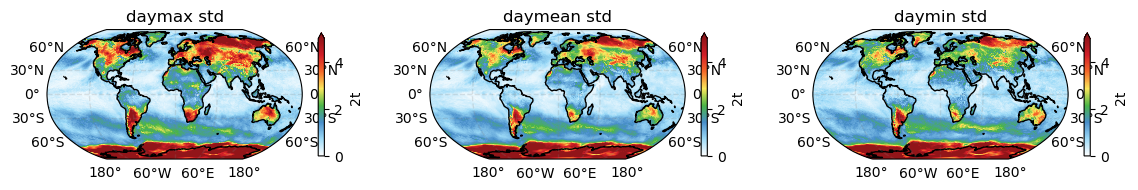

In [5]:
# All three metrics would be suitable to visualise exceptional July heat and all anomaly maps are similar to first order.
# I want to show the evolution of 31 daily fields through July, so let's check which of the fields has lowest time variations
# to get a smooth animation through July.

ts_mean = t2_hourly.resample(time='D').mean()
ts_max = t2_hourly.resample(time='D').max()
ts_min = t2_hourly.resample(time='D').min()

t2_clim_daymean['time'] = ts_mean['time']
t2_clim_daymax['time'] = ts_max['time']
t2_clim_daymin['time'] = ts_min['time']

ts_mean_anomaly = (ts_mean - t2_clim_daymean).std('time')
ts_max_anomaly = (ts_max - t2_clim_daymax).std('time')
ts_min_anomaly = (ts_min - t2_clim_daymin).std('time')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))

plot_map(ts_max_anomaly['2t'], axes[0], 0.0, 5.0, 'daymax std', cmap_WBGYR, cbar_kwargs={'shrink': 0.4})
plot_map(ts_mean_anomaly['2t'], axes[1], 0.0, 5.0, 'daymean std', cmap_WBGYR, cbar_kwargs={'shrink': 0.4})
plot_map(ts_min_anomaly['2t'], axes[2], 0.0, 5.0, 'daymin std', cmap_WBGYR, cbar_kwargs={'shrink': 0.4})

# -> Qualitatively, daymax temps show highest day-to-day variability, especially for land. Might be good to use daymean anomalies,
# as this metric is also easiest to understand/communicate.


/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_27689/2049624531.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])  # Make room for colorbar


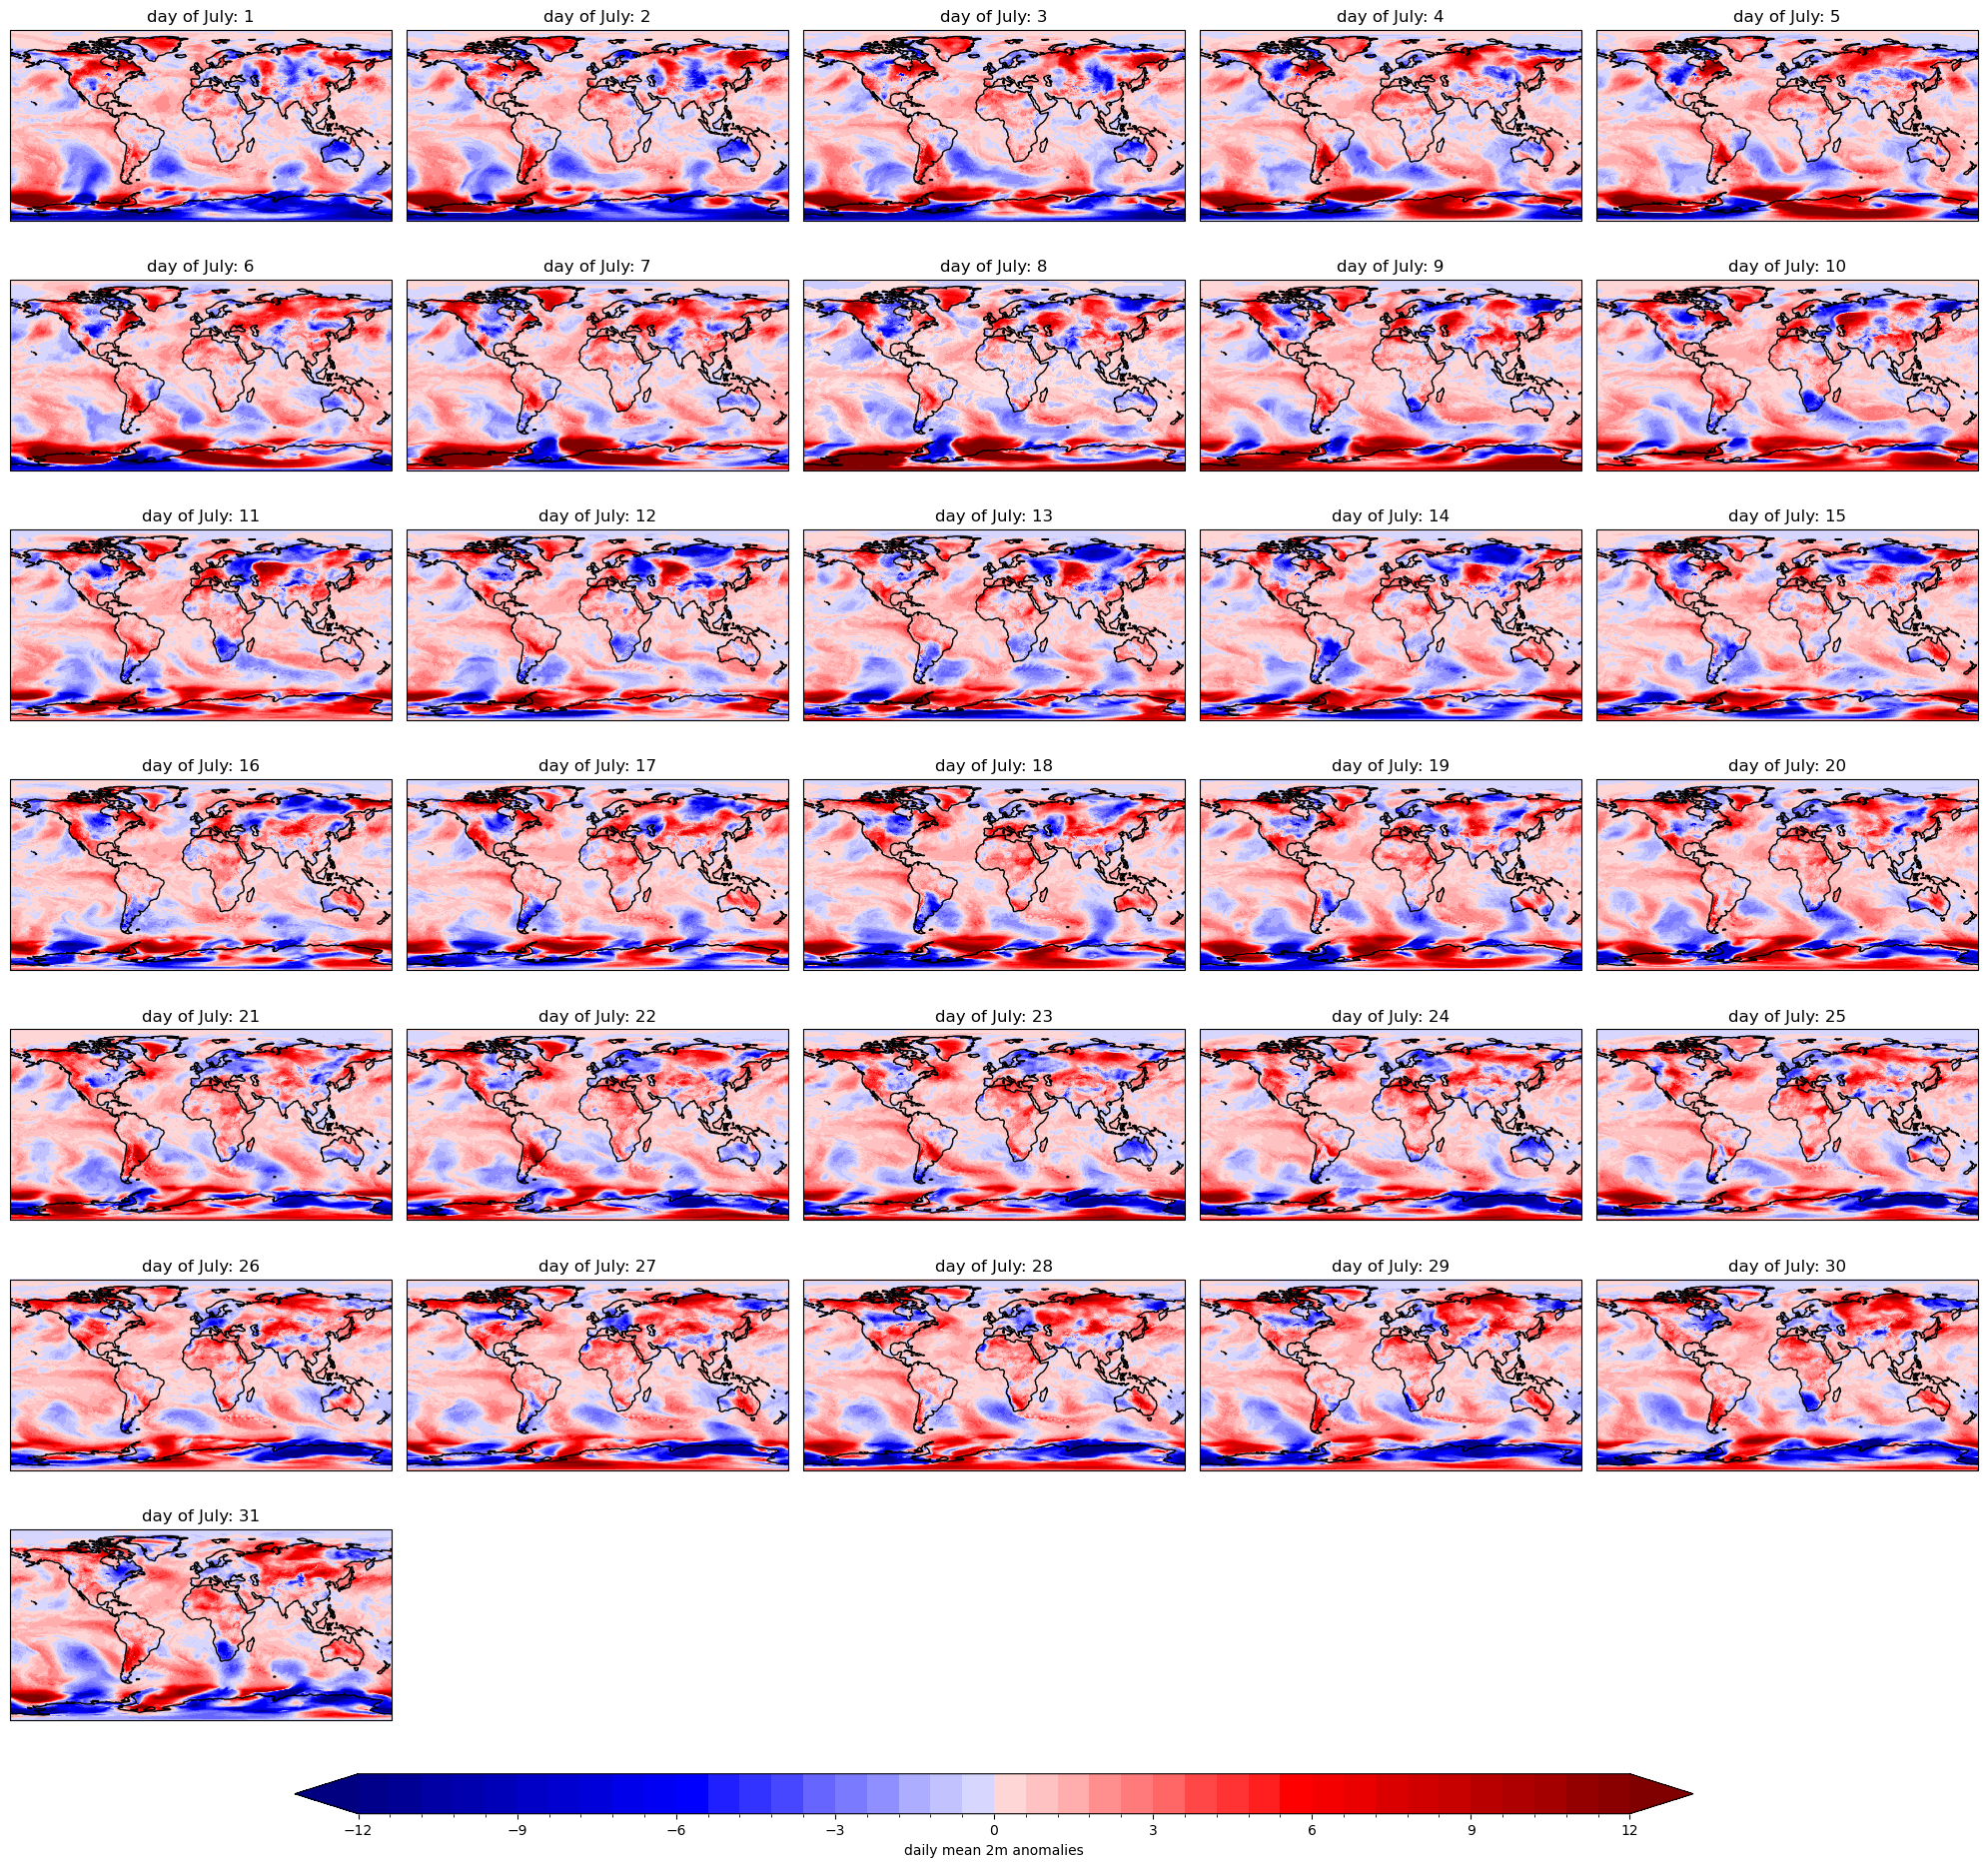

In [6]:
# let's plot the daily mean anomaly fields we want to use for our visualisation
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20), subplot_kw=dict(projection=ccrs.PlateCarree()))

ts_dailymean_anom = ts_mean - t2_clim_daymean

# loop over each day
for time_index, ax in enumerate(axes.ravel()):
    if time_index < 31: 
        im = ts_dailymean_anom['2t'].isel(time=time_index).plot(ax=ax, 
                        transform=ccrs.PlateCarree(), 
                        add_colorbar=False,
                        vmin = -12., vmax = 12.0, levels = 41,
                        cmap = cmap_BR
                        )
        ax.set_title(f"day of July: {time_index+1}")
        ax.coastlines()
    else:
        ax.axis('off')  # Turn off the axes for empty plots

# Add colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # x, y, width, height
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('daily mean 2m anomalies')

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Make room for colorbar
plt.show()

# these daily anomaly fields will build the backbone of the visualisation

## visualisation ideas
July 2023 was the warmest month on record, but monthly mean anomaly maps have been published and discussed extensively. What was also striking was that multiple heat waves occured simultanously around the globe breaking temperature records throughout the whole month. Heatwaves occured in several locations in the Northern Hemisphere, over large parts of the ocean and even in South America during austral winter with strong impacts on human health and the occurences of wildfires. It would be worth to show the temporal evolution of these heatwaves to communicate that these are no longer isolated local events, but rather a global pattern fuled by climate change.

The output is intended for social media. Some thoughts:
- animations work generally better than static images to engage with users
- animation over each day of month 
- ~60 seconds target length suitable for multiple platforms (Twitter, Facebook, TikTok, ...)
- could use ClimateArchive engine for engaging visuals + provide link to interactive version for more interested users

Effective social media require clear communication and clean (i.e. not overloaded figures). Temperature anomalies are already quite difficult to understand for a lot of people, so need to be careful to guide the viewer along the animation.

#### Idea: 
I show temperature anomalies throughout July, but focus on warm anomalies and heatwaves. I start with a uniformly covered Earth surface (maybe gray, like a scratch map) that slowly turns black over the month wherever a heatwave has passed. This should communicate that heatwaves (or well-above average temperatures) were not isolated, but rather global events that impacted the majority of the Earth surface. For each day of JUly I can quantify a cumulative metric of how much of the Earth's surface (or maybe population?) was affected by heatwaves up to that point in the month.

## heatwave threshold
A lot of heatwave definitions exists, good introduction from the [UK MetOffice](https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/wea.3629). I am following the new MetOffice heatwave definition from above link:

- thre consecutive days of daily maximum temp above 90th percentile of the July daily maximum 2m air temperature for 1991-2020
- daily maximum temperature > 25 °C

The 25 °C temperature threshold over land is used by the MetOffice to only select summer days with 'some heat exposure activity risks' (ref: WMO 2015, Heatwaves and Health: Guidance on Warming-System Development, McGregor GR (ed.) WMO No. 1142, Geneva: Switzerland). This is normally not applied to detect [marine heatwaves](http://www.marineheatwaves.org/all-about-mhws.html). For consistency, I also don't apply the '> 25 °C' threshold over land. This means some events should not be called heatwaves, but rather winter warm spells (e.g. in the Arctic or Southern Hemisphere). But even if they are not dangerous for human health, they can still have large implications for local ecosystems, so worth to communicate!

Please note: Marine heatwaves are normally defined by sea surface temperature anomalies, not surface air temperatures! I decided to continue with the 2m air temperature to not deviate too far from the original exercise. To first order, this approach can be justified by the high correlation between SST and T2M, but can lead to inconsistencies, e.g. in high-latitude areas with sea-ice cover. Furthermore, the number of consecutive days above the heatwave threshold used for marine heatwaves is normally 5 days. Again, for simplicity of this exercise I use the same 3 day criteria as for the land.   

I can use the same date range as the provided data, but need slightly diffrent processing. So we need to go bach to access the raw hourly data over the time period 1991-2020 (hope this is OK for the exercise?). We can get data from CDS, either via API or via toolbox application (https://cds.climate.copernicus.eu/toolbox-editor/26376/era5_heatwave_threshold).

In [3]:
# calculate global field of heatwave threshold

# 1. Get hourly 2m temperature between 1991-2020 from CDS API
# skip if file exists
if not os.path.isfile(dir + '/ERA5_2t_hourly_1991-2020.nc'):
    import cdsapi
    c = cdsapi.Client()
    c.retrieve('reanalysis-era5-single-levels', # Requests follow MARS syntax
    {
        'variable':'2m_temperature',
        'product_type':'reanalysis',
        'year': ['%04d' % (year) for year in range(1991,2021)],
        'month': '07',
        'day':['%02d' % (day) for day in range(1,32)],
        'time':['%02d:00' % (hr) for hr in range(24)],
        'area': [-90, -180, 90, 180],
        'grid'    : '0.25/0.25',              
        'format'  : 'netcdf',
    },  'ERA5_2t_hourly_1991-2020.nc')
    
# 2. Use CDO to calculate heatwave threshold
# skip if file exists
if not os.path.isfile(dir + '/ERA5_2t_heatwave_threshold.nc'):
    
    from cdo import *   # CDO python bindings
    cdo = Cdo()

    # calculate daily maximum temperatures
    cdo.daymax(input=dir + '/ERA5_2t_hourly_1991-2020.nc',
               output=dir + '/ERA5_2t_July_daymax.nc',
               options='-f nc4 -z zip_1')

    # calculate 90th percentile of daily maximum temperatures
    cdo.timpctl(90,
                input=[dir + '/ERA5_2t_July_daymax.nc', '-timmin ERA5_2t_July_daymax.nc', '-timmax ERA5_2t_July_daymax.nc'],
                output=dir + '/ERA5_2t_July_daymax_90p.nc',
                options='-f nc4 -z zip_1')
    
    # shift the longitudes by 180 degress for consistency
    cdo.sellonlatbox(0, 360, 90, -90,
                 input=dir + '/ERA5_2t_July_daymax_90p.nc',
                 output=dir + '/ERA5_2t_heatwave_threshold.nc',
                 options='-f nc4')

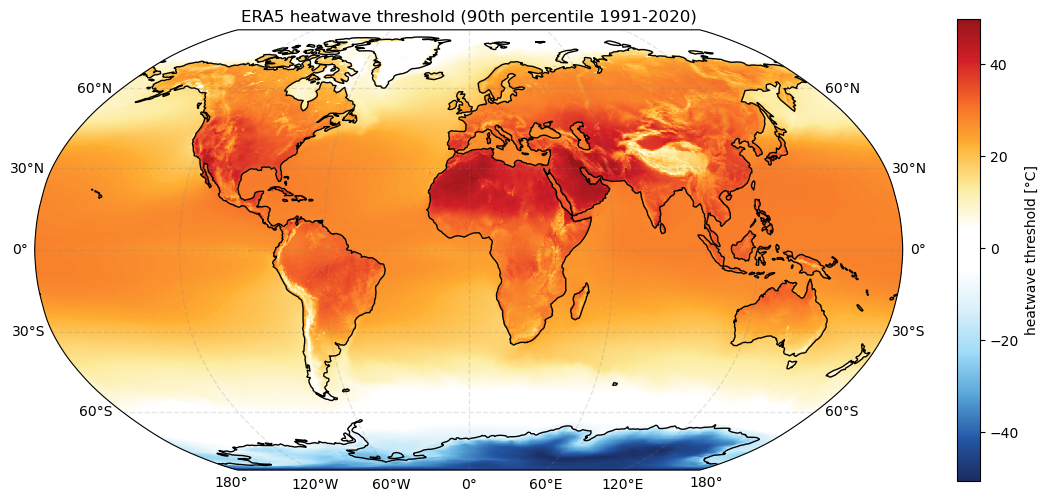

In [163]:
# plot results for quick check
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))

hw_th = xr.open_dataset(dir + "/ERA5_2t_heatwave_threshold.nc").squeeze(dim='time', drop=True)
# convert to °C
hw_th['t2m'] -= 273.15

ax = plot_map(hw_th['t2m'], 
         ax, 
         hw_th['t2m'].min(), 
         hw_th['t2m'].max(), 
         'ERA5 heatwave threshold (90th percentile 1991-2020)', 
         cmap_BWOR,
         cbar_kwargs={'shrink': 0.6, 'label': 'heatwave threshold [°C]'})

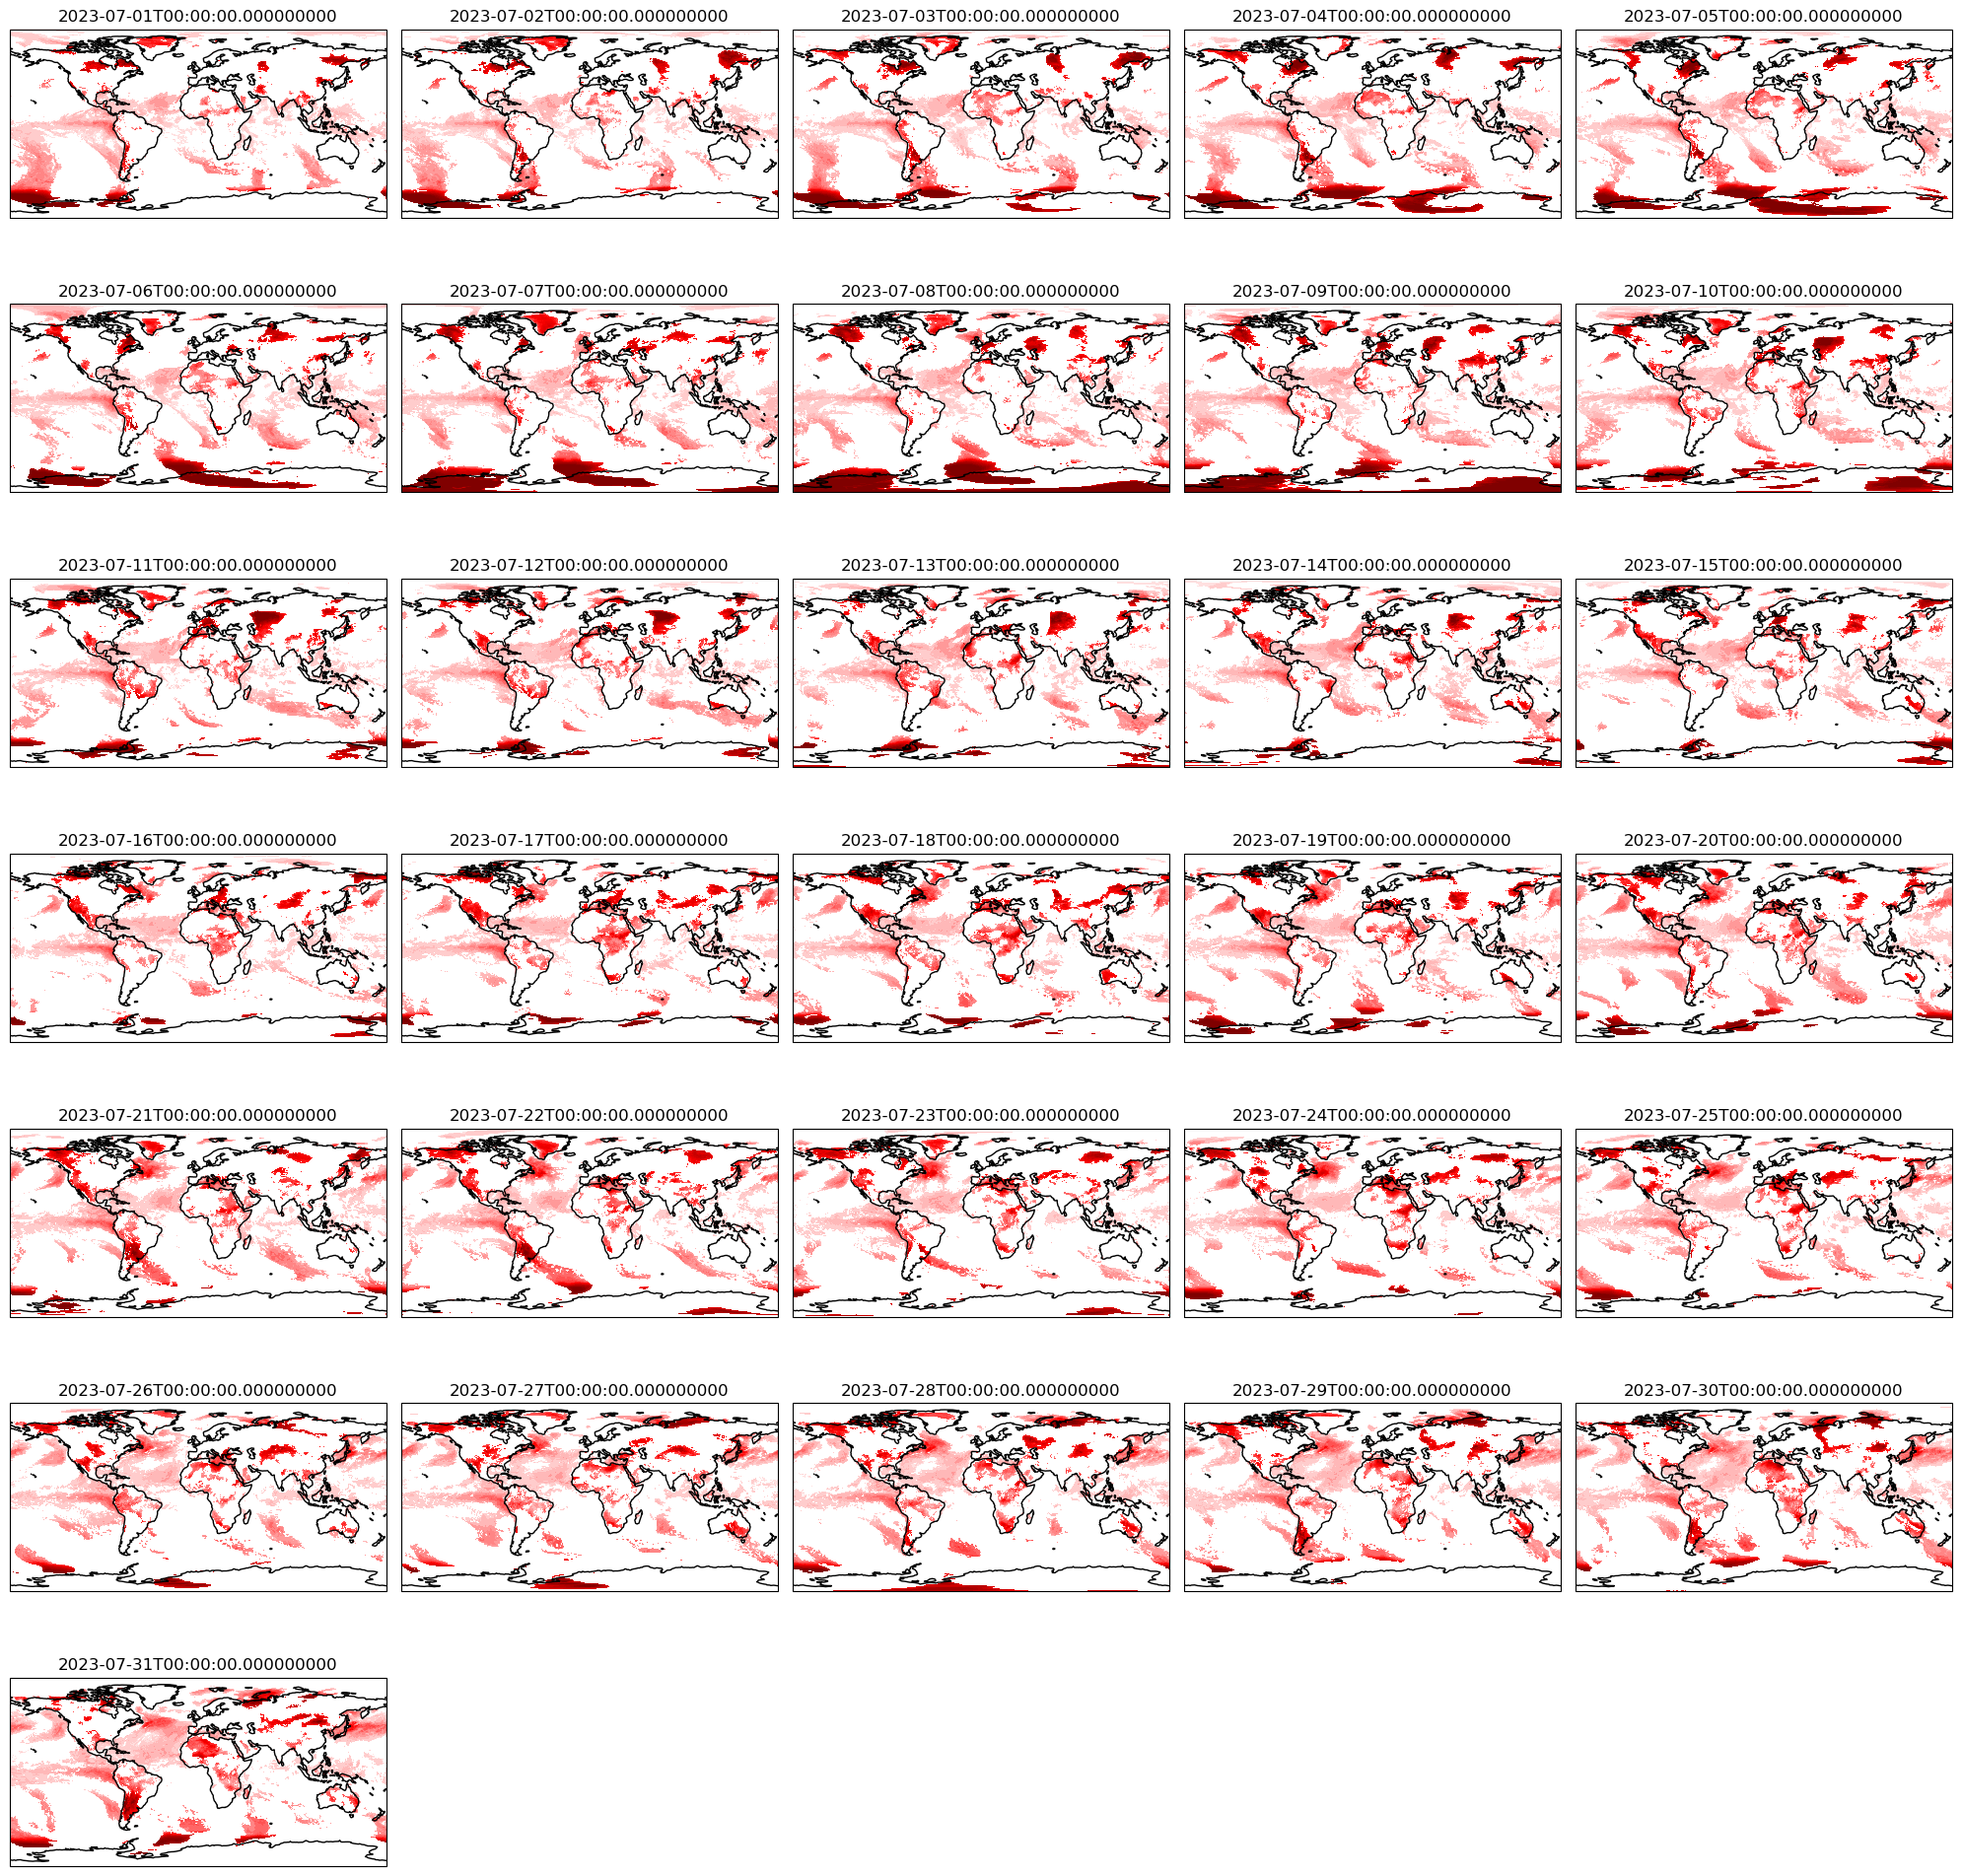

In [6]:
# let's see for each day whether temperatures were above the heatwave threshold 

# get daymax temperatures for 2023
t2_july23_daymax = t2_hourly.resample(time='D').max()

# get heatwave threshold
hw_th = xr.open_dataset(dir + "/ERA5_2t_heatwave_threshold.nc").squeeze(dim='time', drop=True)
# convert to °C
hw_th['t2m'] -= 273.15
# make coordinates compatible
hw_th = hw_th.rename({'latitude': 'lat', 'longitude': 'lon', 't2m': '2t'})

# Plotting the maps as subplots
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20), subplot_kw=dict(projection=ccrs.PlateCarree()))

# loop over each day
for time_index, ax in enumerate(axes.ravel()):
    if time_index < 31: 
        t2_anomaly = t2_july23_daymax['2t'].isel(time=time_index) - t2_clim_daymax['2t'].isel(time=time_index)
        t2_anomaly.where(t2_july23_daymax['2t'].isel(time=time_index) - 273.15 > hw_th['2t']).plot(ax=ax, 
                        transform=ccrs.PlateCarree(), 
                        add_colorbar=False,
                        vmin = -12., vmax = 12.0, levels = 41,
                        cmap = cmap_BR
                        )
        ax.set_title(str(t2_july23_daymax['time'].isel(time=time_index).values))
        ax.coastlines()
    else:
        ax.axis('off')  # Turn off the axes for empty plots

plt.tight_layout()
plt.show()

## Detect heatwaves

In [4]:
# We normally speak of heatwaves when dailymax temperatures exceed the threshold for 3 consecutive days (can be 5 for marine heatwaves,
# but I use a global criteria of 3 for simplicity in this exercise). 
# Therefore, to detect heatwaves at the start and end of July we need to extend the hourly 2m air temperature dataset with
# the last 2 days of June. To be able to calculate some rolling averages or sums I download the last ten days of June and first
# ten days of August. Again, we can use the CDS API for this:

# 1. Get hourly 2m temperature for end of June 2023 from CDS API
# skip if file exists
if not os.path.isfile(dir + '/ERA5_2t_hourly_20230621-20230630.nc'):
    import cdsapi
    c = cdsapi.Client()
    c.retrieve('reanalysis-era5-single-levels', # Requests follow MARS syntax
    {
        'variable':'2m_temperature',
        'product_type':'reanalysis',
        'year': '2023',
        'month': '06',
        'day':['%02d' % (day) for day in range(21,31)],
        'time':['%02d:00' % (hr) for hr in range(24)],
        'area': [-90, -180, 90, 180],
        'grid'    : '0.25/0.25',              
        'format'  : 'netcdf',
    },  'ERA5_2t_hourly_20230621-20230630.nc')

# 2. Get hourly 2m temperature for early August 2023 from CDS API
# skip if file exists
if not os.path.isfile(dir + '/ERA5_2t_hourly_20230801-20230810.nc'):
    import cdsapi
    c = cdsapi.Client()
    c.retrieve('reanalysis-era5-single-levels', # Requests follow MARS syntax
    {
        'variable':'2m_temperature',
        'product_type':'reanalysis',
        'year': '2023',
        'month': '08',
        'day':['%02d' % (day) for day in range(1,11)],
        'time':['%02d:00' % (hr) for hr in range(24)],
        'area': [-90, -180, 90, 180],
        'grid'    : '0.25/0.25',              
        'format'  : 'netcdf',
    },  'ERA5_2t_hourly_20230801-20230810.nc')
    
# 3. Shift longitudes by 180 degress
if not os.path.isfile(dir + '/ERA5_2t_hourly_20230621-20230630.shifted.nc'):
    from cdo import *   # CDO python bindings
    cdo = Cdo()

    cdo.sellonlatbox(0, 360, 90, -90,
                 input=dir + '/ERA5_2t_hourly_20230621-20230630.nc',
                 output=dir + '/ERA5_2t_hourly_20230621-20230630.shifted.nc',
                 options='-f nc4')
    
if not os.path.isfile(dir + '/ERA5_2t_hourly_20230801-20230810.shifted.nc'):
    from cdo import *   # CDO python bindings
    cdo = Cdo()

    cdo.sellonlatbox(0, 360, 90, -90,
                 input=dir + '/ERA5_2t_hourly_20230801-20230810.nc',
                 output=dir + '/ERA5_2t_hourly_20230801-20230810.shifted.nc',
                 options='-f nc4')
    
# 3. add new data to hourly record
t2_hourly_June = xr.open_dataset(dir + "/ERA5_2t_hourly_20230621-20230630.shifted.nc")
t2_hourly_August = xr.open_dataset(dir + "/ERA5_2t_hourly_20230801-20230810.shifted.nc")

# make coordinates compatible
t2_hourly_June = t2_hourly_June.rename({'latitude': 'lat', 'longitude': 'lon', 't2m': '2t'})
t2_hourly_August = t2_hourly_August.rename({'latitude': 'lat', 'longitude': 'lon', 't2m': '2t'})

t2_hourly_JJA = xr.concat([t2_hourly_June, t2_hourly, t2_hourly_August], dim='time')

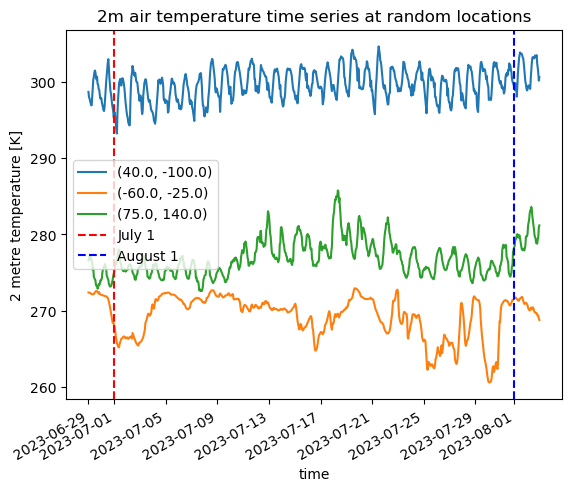

In [168]:
# quick check whether the data was merged correctly by plotting a time series at some random points
locations = [(40.0, -100.0), (-60.0, -25.0), (75.0, 140.0)]

for lat, lon in locations:
    # point_data = t2_hourly_JJA.sel(time=slice('2023-06-29', '2023-07-03')).sel(lat=lat, lon=lon, method='nearest')
    point_data = t2_hourly_JJA.sel(time=slice('2023-06-29', '2023-08-02')).sel(lat=lat, lon=lon, method='nearest')
    point_data['2t'].plot(label=f'({lat}, {lon})')

# highlight merge time
plt.axvline(pd.Timestamp('2023-07-01T00:00:00'), color='r', linestyle='--', label='July 1')
plt.axvline(pd.Timestamp('2023-08-01T00:00:00'), color='b', linestyle='--', label='August 1')

plt.title('2m air temperature time series at random locations')
plt.legend()
plt.show()

# everything seems fine!

In [7]:
# now let's compute the heatwave threshold and some cumulative metrics for the visualisation

# first calculate whether each day exceeds the heatwave threshold

# get daymax temperatures for the combined record
t2_daymax_JJA = t2_hourly_JJA.resample(time='D').max() - 273.15
# broadcast the threshold to the same dimensions as the measurements
hw_th_broadcasted = hw_th.expand_dims({'time': t2_daymax_JJA['time']}).broadcast_like(t2_daymax_JJA)
# create a new array where the theshold is met
instantaneous_heatwave_flag = xr.where(t2_daymax_JJA['2t'] > hw_th_broadcasted['2t'], 1, 0)

# now check for three consecutive days to fullfill heatwave definition

# Create the sum of a rolling window of 3 days along the 'time' dimension
sum_rolling_window = instantaneous_heatwave_flag.rolling(time=3, center=True).sum()
# Check if the sum is at least 3 (meaning 'instantaneous_heatwave_flag' is 1 for at least 3 consecutive days)
at_least_three_day_heatwave = xr.where(sum_rolling_window == 3, 1, 0)

# let's create a flag to record whether any point has already experienced a heatwave (up to that point in July)
# this will be helpful to slowly reveal more parts of the Earth that experienced heatwaves over the course of July

# Calculate the cumulative sum along the time dimension
cumulative_sum = at_least_three_day_heatwave.sel(time=slice('2023-07-01', '2023-07-31')).cumsum(dim='time')
# Create a new variable that is 1 if the cumulative sum is at least 1 (i.e., if the heatwave condition has been met at least once up to that time)
ever_had_three_day_heatwave = xr.where(cumulative_sum >= 1, 1, 0)

# Finally, calculate the cumulative number of heatwave days over July to see which areas had persistent heatwave conditions
# as both intensity and duration have impact on human health
monthly_heatwave_days = instantaneous_heatwave_flag.sel(time=slice('2023-07-01', '2023-07-31')).cumsum(dim='time')
# monthly_heatwave_days = xr.where(monthly_heatwave_days >= 3, monthly_heatwave_days, 0)

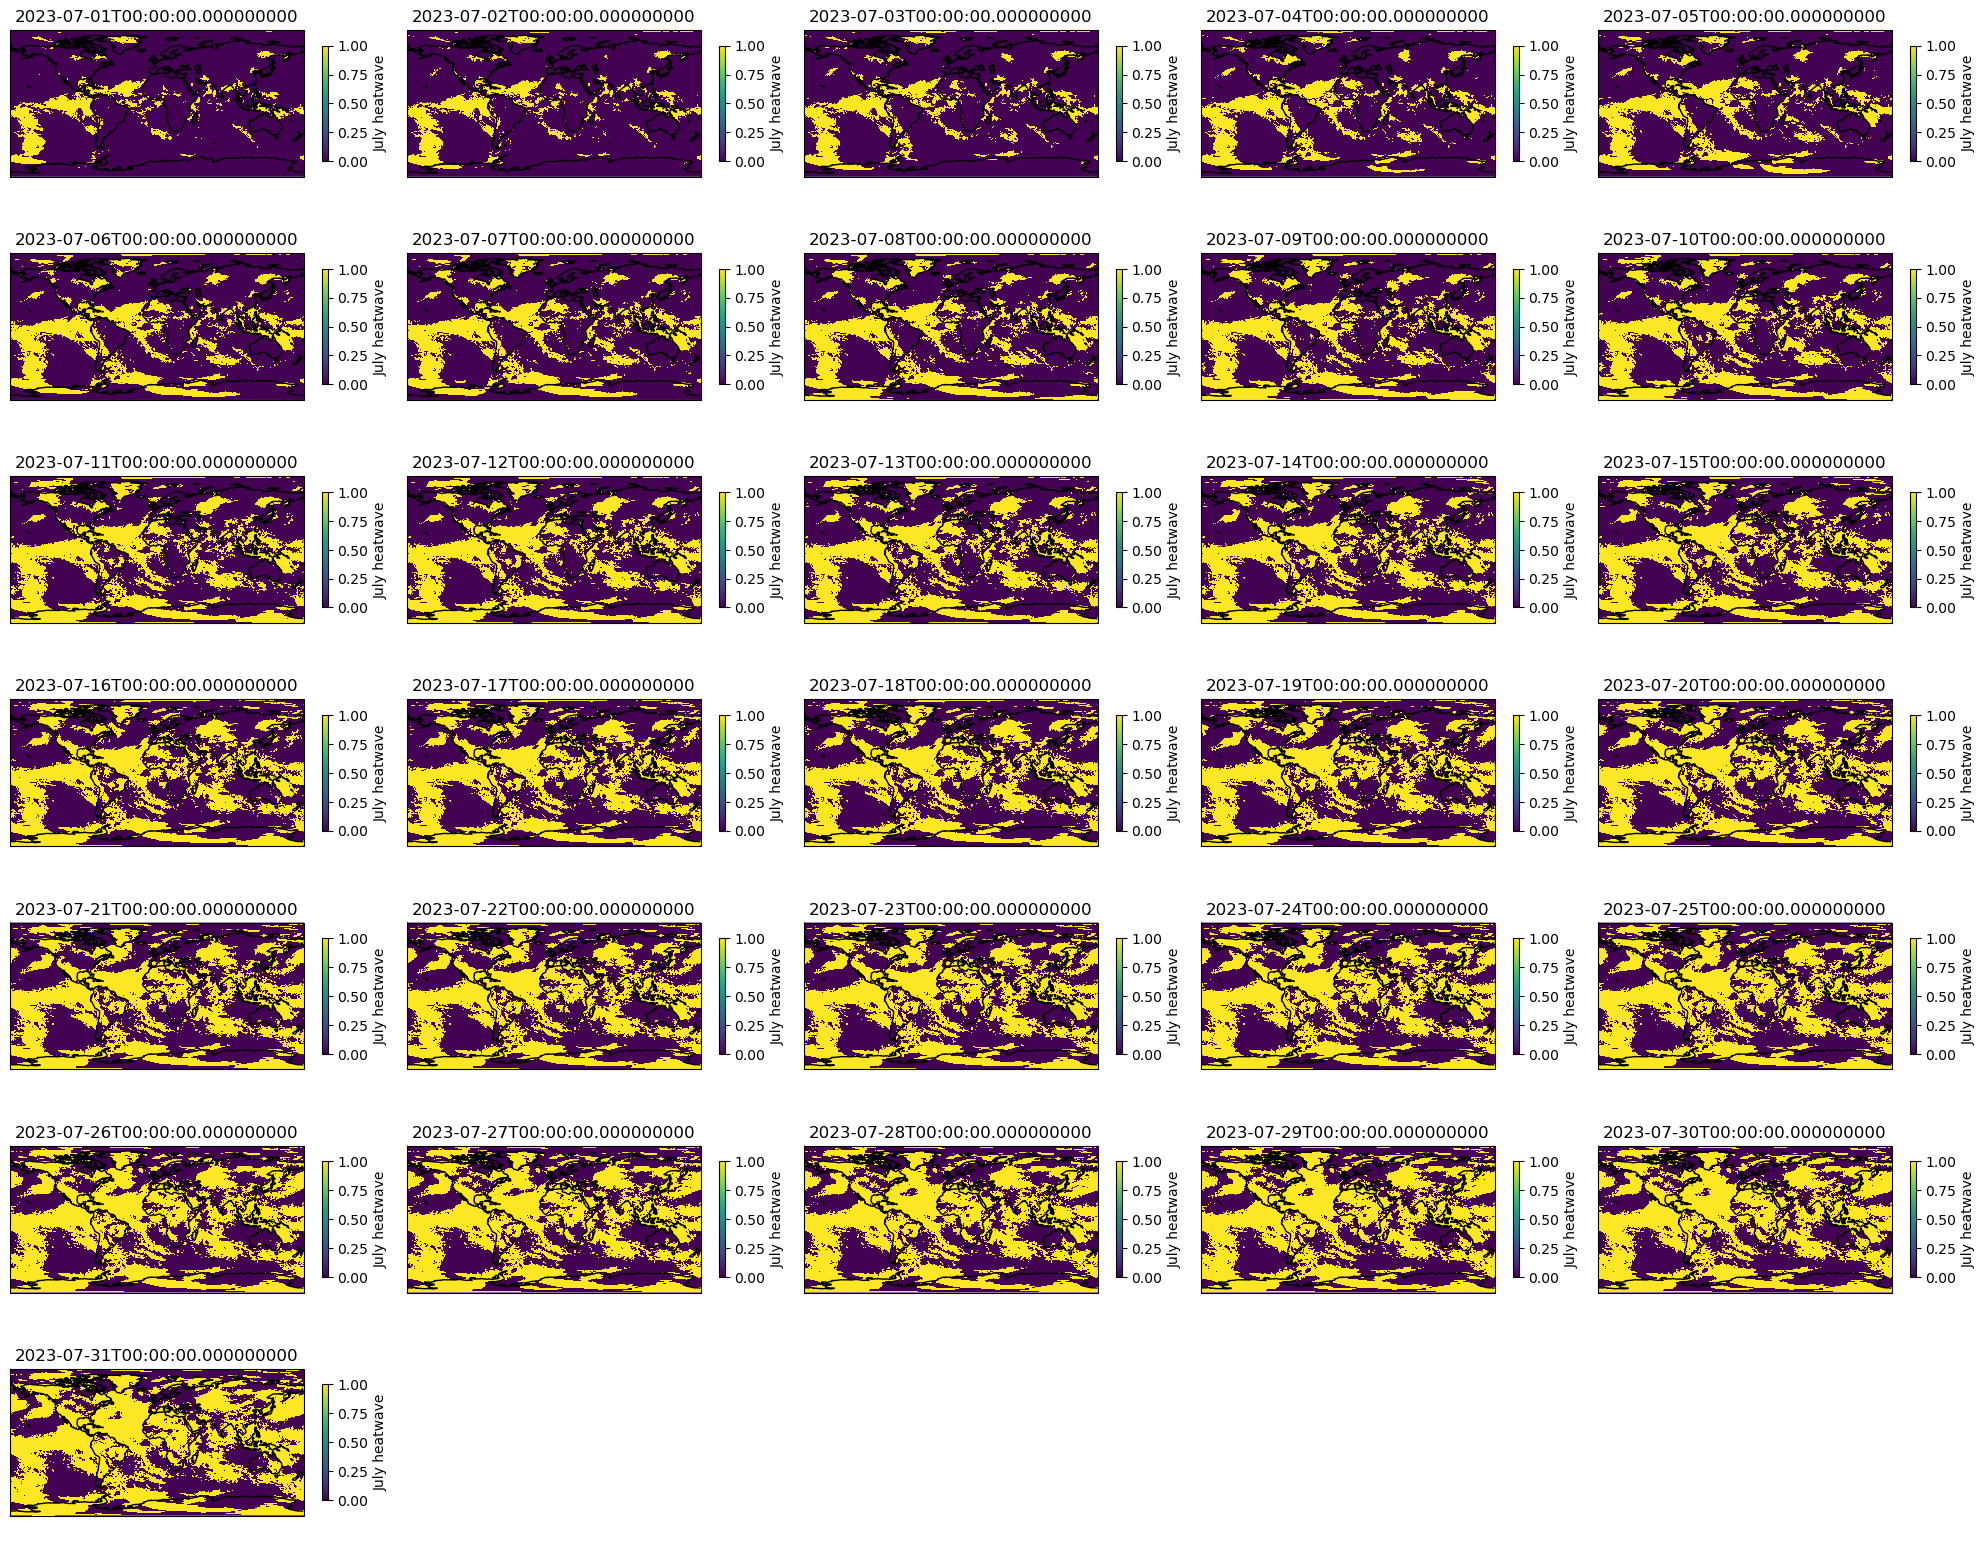

In [77]:
# Check maps of the cumulative heatwave metric
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 16), subplot_kw=dict(projection=ccrs.PlateCarree()))

# loop over each day
for time_index, ax in enumerate(axes.ravel()):
    if time_index < 31:
        ever_had_three_day_heatwave.isel(bnds=0).isel(time=time_index).plot(ax=ax, 
                        transform=ccrs.PlateCarree(), 
                        cbar_kwargs={'label': 'July heatwave', 'shrink': 0.5}
                        )
        ax.set_title(str(ever_had_three_day_heatwave['time'].isel(time=time_index).values))
        ax.coastlines()
    else:
        ax.axis('off')  # Turn off the axes for empty plots

plt.tight_layout()
plt.show()

# It looks like most of the globe has experienced at least one 3-day heatwave (or warm spell in colder regions) over the course of July!
# This is quite striking and should be included in the visualisation!

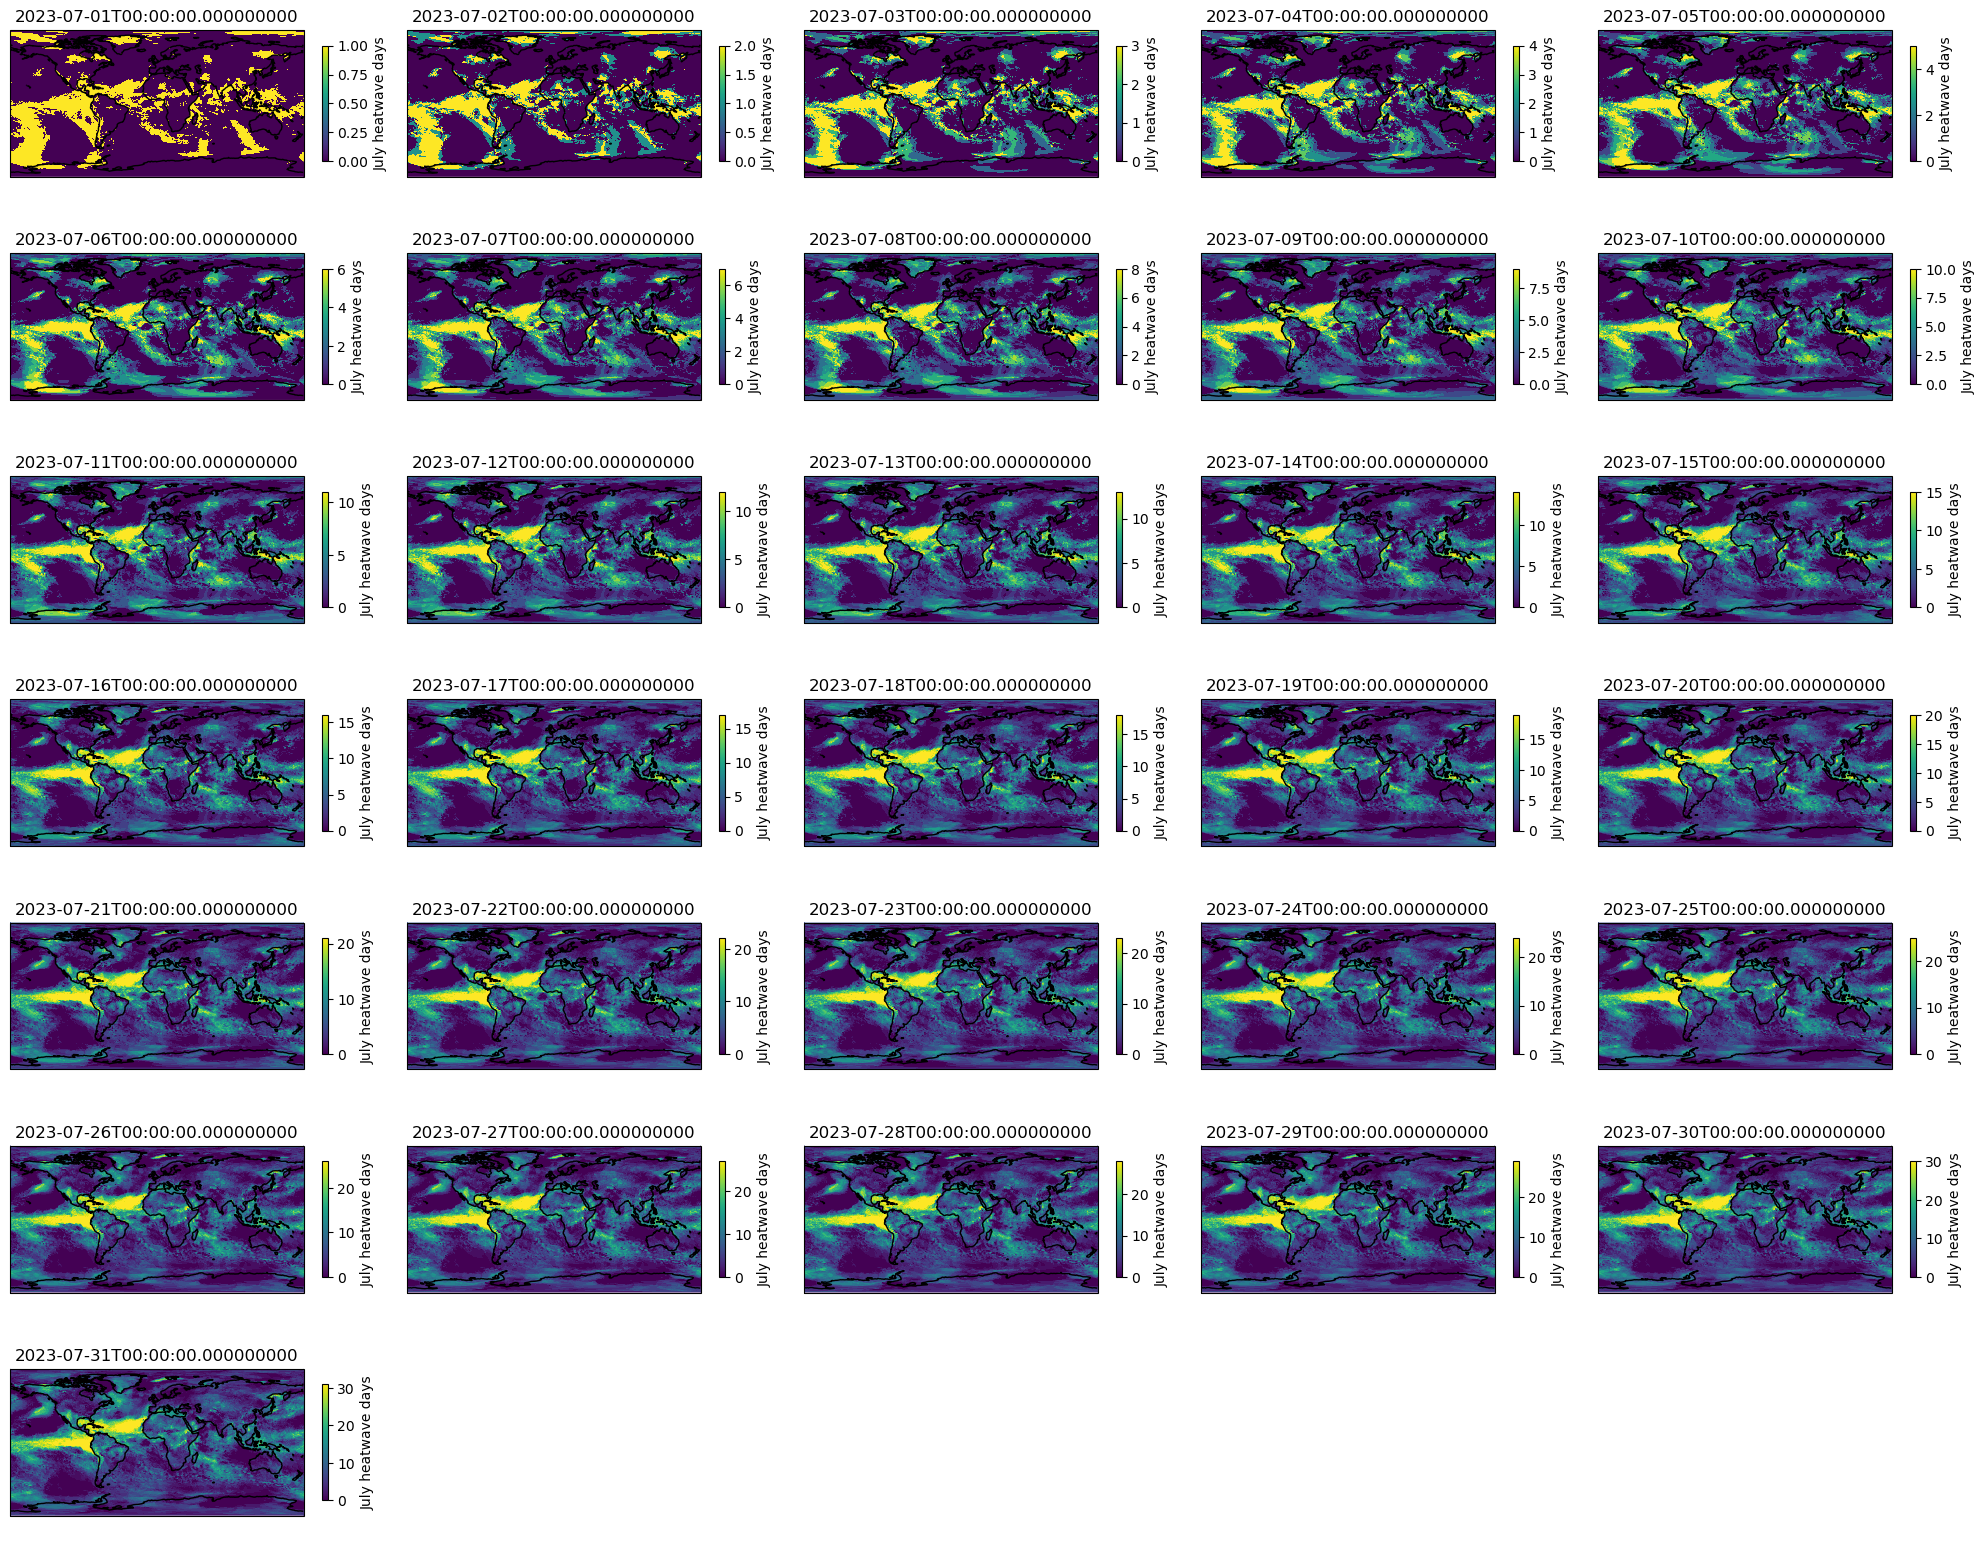

In [8]:
# Check maps of the monthly heatwave days
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 16), subplot_kw=dict(projection=ccrs.PlateCarree()))

# loop over each day
for time_index, ax in enumerate(axes.ravel()):
    if time_index < 31:
        monthly_heatwave_days.isel(bnds=0).isel(time=time_index).plot(ax=ax, 
                        transform=ccrs.PlateCarree(), 
                        cbar_kwargs={'label': 'July heatwave days', 'shrink': 0.5}
                        )
        ax.set_title(str(monthly_heatwave_days['time'].isel(time=time_index).values))
        ax.coastlines()
    else:
        ax.axis('off')  # Turn off the axes for empty plots

plt.tight_layout()
plt.show()

# Quite interesting distribution, might be worth to include the last day of the month at the end of the visualisation. Clearly, 
# the persistent marine heatwaves in equatorial Pacific and Atlantic stand out. 

## Global mean metrics
Let's quantify these results in some global mean metrics that can be used to better understand the temporal changes over July.
These global values can also be added to the visualisation to communicate some headline statements.

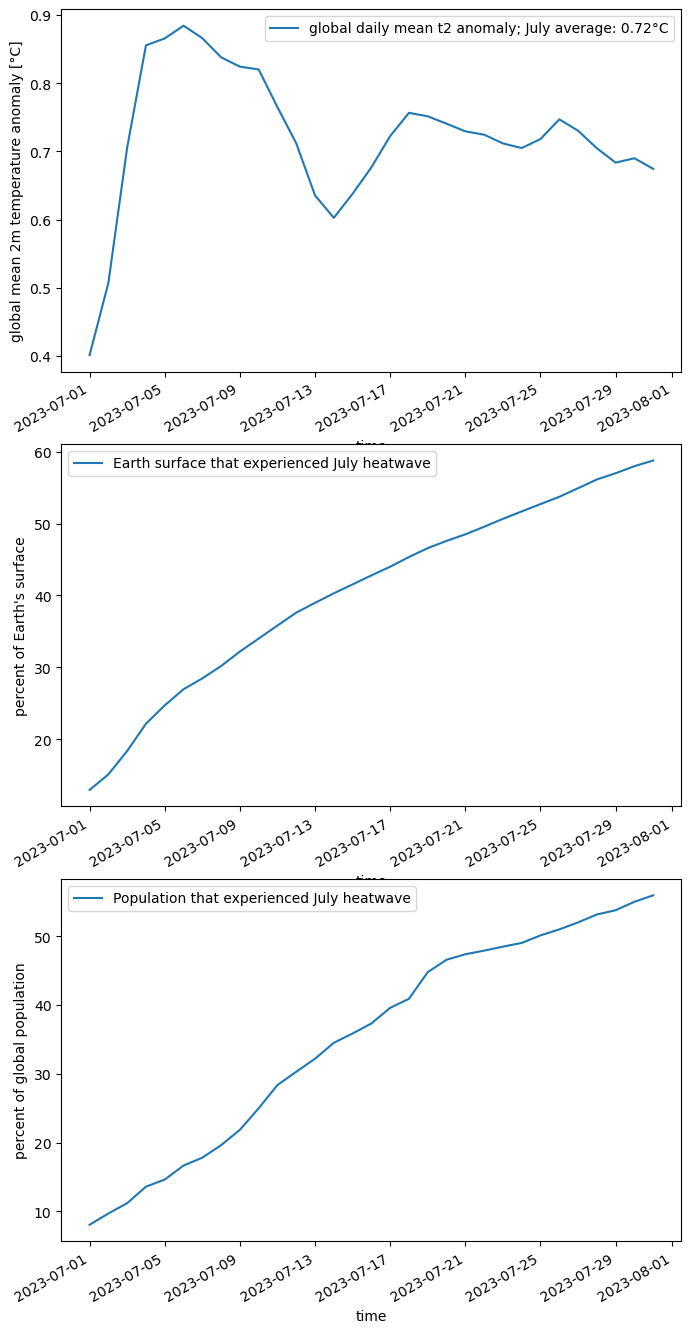

In [153]:
# calculate the weights for the global means
lat_rad = np.deg2rad(ts_dailymean_anom['lat'])
weights = np.cos(lat_rad)

fig, ax = plt.subplots(3, figsize=(8, 16))

# 1. global mean temperature anomaly
gm_temp_anomaly = ts_dailymean_anom['2t'].weighted(weights).mean(dim=['lat', 'lon'])

# 2. fraction of Earth's surface that experienced a heatwave in July up to that date
heatwave_mask = ever_had_three_day_heatwave.isel(bnds=0) == 1.0
# weight the mask by the area weights
weighted_mask = heatwave_mask.weighted(weights)
# sum over latitude and longitude dimensions to get the global area for each day
global_area_heatwave = weighted_mask.sum(dim=['lat', 'lon'])
# calculate the total weighted surface area of the Earth
total_weighted_area = weights.sum(dim='lat') * ts_dailymean_anom['lon'].size
global_area_heatwave = (global_area_heatwave / total_weighted_area) * 100

# number of people affected by at least one July 2023 heatwave
# let's add one final metric due to the potential impacts of heatwaves on human health
# load GPWv4 dataset (https://sedac.ciesin.columbia.edu/data/collection/gpw-v4 )
# which contains global, gridded population data at the same resolution as ERA5 (used CDO to adjust grid) 
ds_pop = xr.open_dataset(dir + "/gpw-v4-population-count-rev11_totpop_15_min_nc/gpw_v4_population_count_rev11_15_min.ERA5-grid.nc").squeeze()
# Multiply the heatwave mask with the population dataset to get the population living in heatwave areas
population_in_heatwave = heatwave_mask * ds_pop['Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes']
# Sum over latitude and longitude dimensions to get the global population for each day
global_population_in_heatwave = population_in_heatwave.sum(dim=['lat', 'lon'])
# again, get global population to calculate fraction
global_pop = ds_pop['Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes'].sum(dim=['lat', 'lon'])
global_population_in_heatwave = (global_population_in_heatwave / global_pop) * 100

# plot the time series
gm_temp_anomaly.plot(
    ax = ax[0],
    label=f'global daily mean t2 anomaly; July average: {gm_temp_anomaly.mean().values:.2f}°C'
    )
ax[0].axes.set_ylabel('global mean 2m temperature anomaly [°C]')
lg = ax[0].legend()

global_area_heatwave.plot(
    ax = ax[1],
    label=f'Earth surface that experienced July heatwave'
    )
ax[1].axes.set_ylabel('percent of Earth\'s surface')
lg = ax[1].legend()

global_population_in_heatwave.plot(
    ax = ax[2],
    label=f'Population that experienced July heatwave'
    )
ax[2].axes.set_ylabel('percent of global population')
lg = ax[2].legend()

# -> sanity check: whole-month average of 0.7°C is consistent with Copernicus release
# https://climate.copernicus.eu/surface-air-temperature-july-2023
# nearly 60% of the surface had at least one heatwave in July 2023 and more than
# half of the global population was affecetd! 
# these results should be added to the visualisation


In [183]:
# export the data to CSV

# convert to a pandas DataFrame
df_temp = gm_temp_anomaly.to_dataframe()
df_area = global_area_heatwave.to_dataframe(name='area_frac')
df_pop = global_population_in_heatwave.to_dataframe(name='pop_frac')
# combine the DataFrames
df_combined = pd.concat([df_temp, df_area, df_pop], axis=1)

# start with zero affected fractions for animation
df_combined.loc['2023-07-01 00:00:00', 'area_frac'] = 0.0
df_combined.loc['2023-07-01 00:00:00', 'pop_frac'] = 0.0

# write to disk
df_combined.to_csv('July_global_mean_metrics.csv')

## export processed data to ClimateArchive for visualisation
I will use the ClimateArchive engine to visualise the results in 3D. The engine runs in a web browser and uses
bitmap images to read in the data. I use the PNG image format for lossless compression. The data is encoded
in the RGB channels of the bitmap and global fields are saved for each day and combined in one large bitmap, similar
to a movie strip.

In [184]:
from PIL import Image

# define output array that will be written to the disk as a RGB bitmap
num_lat = t2_july23_daymax.sizes['lat']
num_lon = t2_july23_daymax.sizes['lon']
num_time = t2_july23_daymax.sizes['time']

output_data      = np.zeros( ( num_lat, num_lon * num_time, 3 ) )

# function to normalize data to range 0-1
def norm(arr, norm_min, norm_max):
    return (arr - norm_min) / (norm_max - norm_min)

for index in range(num_time):

    # temperature anomalies in red channel
    # normalise values to [0,255]
    output_data[:,index*num_lon : ((index+1)*num_lon),0] = norm(ts_dailymean_anom['2t'].isel(time=index), -10., 10.) * 255 
    
    # cumulative number of heatwave days for last day of July in green channel
    if index == num_time-1:
        output_data[:,index*num_lon : ((index+1)*num_lon),1] = norm(monthly_heatwave_days.isel(bnds=0).isel(time=index), 0., 31.) * 255.
    
    # cumulative heatwave index in blue channel
    # start with zeroes for animation
    if index == 0:
        output_data[:,index*num_lon : ((index+1)*num_lon),2] = 0.
    else:
        output_data[:,index*num_lon : ((index+1)*num_lon),2] = ever_had_three_day_heatwave.isel(bnds=0).isel(time=index) * 255.

    # cap values to chosen dynamic range
    output_data[output_data > 255] = 255
    output_data[output_data < 0] = 0

# convert to 8-bit integers
output_data = output_data.astype(np.uint8)

# save file to bitmap on disk
im = Image.fromarray(output_data)
im.save(dir + '/ERA5_July_2023_heatwaves_ClimateArchive.png', optimize=True)